In [99]:
# 出走馬について上位に入る確率を予想し、確率が閾値以上の場合に限り購入することを考える
# 閾値を使わずに購入した場合と閾値以上の場合で比較し、的中率や回収率が改善されるか確認する

In [847]:
# インポート
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
# ! pip install japanize-matplotlib
import japanize_matplotlib
from scipy import stats

In [849]:
# CSVファイルの読み込み
# df = pd.read_csv('input_編集後.csv', encoding='utf-8')
num_horses = 9
df = pd.read_csv(f'input_{num_horses}頭_編集後.csv', encoding='utf-8')
df['race_date'] = pd.to_datetime(df['race_date'])  # 日付が文字列なら変換
print(f"dfの行数は {len(df)} ")
# レースID、馬番順に並び替え
df = df.sort_values(by=['race_id', 'horse_number'])

dfの行数は 78768 


In [851]:

def confidence_interval(mean: float, std: float, n: int, confidence: float = 0.95):

    """
    回収率の信頼区間を求める関数

    Parameters
    ----------
    mean       : float           平均回収率（例：1.05）
    std        : float           標準偏差  （例：0.15）
    n          : int             サンプル数（レース数）
    confidence : float, optional 信頼水準（デフォルトは0.95）

    Returns
    -------
    (lower, upper) : tuple of float
        信頼区間の下限値と上限値
    """
    
    # t値（t分布の臨界値）
    t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
    
    # 信頼区間の幅（マージン）
    margin = t_value * std / np.sqrt(n)
    
    # 区間の下限・上限
    lower = mean - margin
    upper = mean + margin
    
    return lower, upper
    

In [853]:
# === 欠損値対応の設定 ===
handle_missing = True  # Trueで対応ON、Falseでスキップ
min_non_missing_horses = num_horses  # この頭数以上であれば補完、それ未満ならレースごと除外

# 欠損処理対象の特徴量を指定（必要に応じて拡張）
missing_check_features = [
    'time_index_average_2',
    'jockey_place_rate_100'
]

def handle_missing_val(df, features, enabled, min_horses):
    if not enabled:
        print("⚠ 欠損処理はスキップされました。")
        return df

    print("✅ 欠損処理を開始します...")
    valid_race_ids = []
    processed_groups = []

    for race_id, group in df.groupby('race_id'):
        # 欠損がない行数をカウント
        non_missing_mask = group[features].notnull().all(axis=1)
        non_missing_count = non_missing_mask.sum()

        if non_missing_count < min_horses:
            # → 指定頭数未満 → 除外
            continue
        else:
            # → 指定頭数以上 → 平均値で補完
            for col in features:
                if group[col].isnull().any():
                    mean_val = group[col].mean(skipna=True)
                    group[col] = group[col].fillna(mean_val)
            processed_groups.append(group)

    df_processed = pd.concat(processed_groups, ignore_index=True)
    print(f"✅ 欠損処理後のレコード数: {len(df_processed)}（元: {len(df)}）")
    return df_processed

# === 欠損処理の実行 ===
df_not_handle_missing_val = df.copy()
df_handle_missing_val = handle_missing_val(
    df_not_handle_missing_val,
    features=missing_check_features,
    enabled=handle_missing,
    min_horses=min_non_missing_horses
)


✅ 欠損処理を開始します...
✅ 欠損処理後のレコード数: 46701（元: 78768）


In [855]:
# ---------- 説明変数 ----------------------------
df_feature = df_handle_missing_val.copy()
race_avg_time_index = df_feature.groupby('race_id')['time_index_average_2'].transform('mean')
df_feature['time_index_diff_from_avg'] = df_feature['time_index_average_2'] - race_avg_time_index
race_avg_jockey_place_rate = df_feature.groupby('race_id')['jockey_place_rate_100'].transform('mean')
df_feature['jockey_place_rate_diff_from_avg'] = df_feature['jockey_place_rate_100'] - race_avg_jockey_place_rate
features = [
    'time_index_diff_from_avg',
    'jockey_place_rate_diff_from_avg',
]
# ---------- リーク防止のラベル一括作成 ----------
# 上位4頭 → is_top4
df_feature['is_top4'] = (
    df_feature.groupby('race_id')['finish_rank']
    .rank(method='first') <= num_horses / 2 
).astype(int)

df_feature.to_csv('C:\\Users\\ryo\\Downloads\\df_feature.csv', index=False, encoding='cp932')

In [857]:
# フィルタ条件を適用
filtered_df = df_feature.copy()
## 年
train_year = 2023
valid_year = 2024
if train_year < valid_year:
    min_year = train_year
    max_year = valid_year
else:
    min_year = valid_year
    max_year = train_year
filtered_df = filtered_df[
    (filtered_df['race_date'].dt.year >= min_year) &
    (filtered_df['race_date'].dt.year <= max_year)
]
## 人気
# filtered_df = filtered_df[filtered_df['popularity'] == 2]

# カウント
print(f"filtered_dfの行数は {len(filtered_df)} ")

filtered_dfの行数は 20403 


In [859]:
# ---------- モデル1 ----------
df_m1 = filtered_df.copy()

# ---------- 各モデルの特徴量と目的変数 ----------
X_m1 = df_m1[features]
y_m1 = df_m1['is_top4']

X_m1.to_csv('C:\\Users\\ryo\\Downloads\\X_m1.csv', index=False, encoding='cp932')
y_m1.to_csv('C:\\Users\\ryo\\Downloads\\y_m1.csv', index=False, encoding='cp932')

# ---------- モデル1の学習 ----------
X_train_m1 = X_m1[df_m1['race_date'].dt.year == train_year]
y_train_m1 = y_m1[df_m1['race_date'].dt.year == train_year]
X_val_m1   = X_m1[df_m1['race_date'].dt.year == valid_year]
y_val_m1   = y_m1[df_m1['race_date'].dt.year == valid_year]

print(len(X_train_m1), len(y_train_m1), len(X_val_m1), len(y_val_m1))

base_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'random_state': 42,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

model1 = xgb.XGBClassifier(
    **base_params,
    base_score = 0.5,
    max_depth=1,
    learning_rate=0.06,
    n_estimators=100,
    reg_alpha=0.5,
    reg_lambda=1.0
)
model1.fit(X_train_m1, y_train_m1)

X_train_m1.to_csv('C:\\Users\\ryo\\Downloads\\X_train_m1.csv', index=False, encoding='cp932')
y_train_m1.to_csv('C:\\Users\\ryo\\Downloads\\y_train_m1.csv', index=False, encoding='cp932')
X_val_m1.to_csv('C:\\Users\\ryo\\Downloads\\X_val_m1.csv', index=False, encoding='cp932')
y_val_m1.to_csv('C:\\Users\\ryo\\Downloads\\y_val_m1.csv', index=False, encoding='cp932')

# ============================================================
# ✅ 推論フェーズ（レース単位で順にモデルを適用して1着を予測）
# ============================================================

# 対象とする検証データのみ
df_test = filtered_df[filtered_df['race_date'].dt.year == valid_year].copy()

df_test.to_csv('C:\\Users\\ryo\\Downloads\\tmp.csv', index=False, encoding='cp932')

# 結果格納リスト
full_predictions = []

for race_id, group in df_test.groupby('race_id'):

    # ---------- モデル1 ----------
    group_m1 = group.copy()
    X_test_m1 = group_m1[features]
    group_m1['pred_prob_m1'] = model1.predict_proba(X_test_m1)[:, 1]
    # 上位4頭を選出
    group_m1 = group_m1.sort_values('pred_prob_m1', ascending=False)
    group_m1['selected_in_m1'] = 0
    num = int(num_horses / 2)
    group_m1.iloc[:num, group_m1.columns.get_loc('selected_in_m1')] = 1

    # ✅ finish_rank も含めて出力
    result_cols = [
        'race_id', 'course_id', 'num_horses', 'race_number', 'weather_name', 'track_condition_name', 'horse_number', 'finish_rank', 'popularity', 'odds', 'pred_prob_m1', 'selected_in_m1'
    ] + features

    full_predictions.append(group_m1[result_cols])

# 全レース結合
full_pred_df = pd.concat(full_predictions, ignore_index=True)

# CSV出力
full_pred_df.to_csv('C:\\Users\\ryo\\Downloads\\race_predictions_all_stages.csv', index=False, encoding='cp932')

print("finish_rank を含めた全段階の予測結果CSVを出力しました。")

### モデルの評価 ###

# モデル1
m1_preds = full_pred_df[full_pred_df['selected_in_m1'] == 1]
m1_total = len(m1_preds)
m1_hits = (m1_preds['finish_rank'] <= num_horses / 2).sum()
m1_accuracy = m1_hits / m1_total if m1_total > 0 else 0

# 出力
print(f"▼ モデル1（上位{int(num_horses / 2)}頭予測）の的中率")
print(f"  予測数: {m1_total}, 的中数: {m1_hits}, 的中率: {m1_accuracy:.4f}（{m1_accuracy:.2%}）\n")

# CSV出力
full_pred_df.to_csv('C:\\Users\\ryo\\Downloads\\full_pred_df.csv', index=False, encoding='cp932')

# ============================
# 人気ごとの1着予想的中率＆回収率
# ============================

# 各レースで pred_prob_m1 が最大の馬を1着予想として抽出
df_pred_top1 = full_pred_df.loc[full_pred_df.groupby('race_id')['pred_prob_m1'].idxmax()].copy()

# 的中フラグ
df_pred_top1['is_hit'] = (df_pred_top1['finish_rank'] == 1).astype(int)

# bet金額（1レースあたり固定）を設定
bet_amount = 100
df_pred_top1['payout'] = df_pred_top1['is_hit'] * df_pred_top1['odds'] * bet_amount

# 人気ごとに集計
pop_stats = df_pred_top1.groupby('popularity').agg(
    total_pred=('is_hit', 'count'),
    hits=('is_hit', 'sum'),
    total_payout=('payout', 'sum')
).reset_index()

# 的中率
pop_stats['accuracy'] = pop_stats['hits'] / pop_stats['total_pred']

# 投資総額（1レースあたり bet_amount）
pop_stats['total_bet'] = pop_stats['total_pred'] * bet_amount

# 回収率（ROI）
pop_stats['roi'] = pop_stats['total_payout'] / pop_stats['total_bet']

# 出力
print("\n📊 人気ごとの1着予想的中率＆回収率（pred_prob_m1最大の馬を1着予想として集計）")
print(pop_stats[['popularity', 'total_pred', 'hits', 'accuracy', 'roi']])


10323 10323 10080 10080


C:\Users\ryo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:19:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


finish_rank を含めた全段階の予測結果CSVを出力しました。
▼ モデル1（上位4頭予測）の的中率
  予測数: 4480, 的中数: 2891, 的中率: 0.6453（64.53%）


📊 人気ごとの1着予想的中率＆回収率（pred_prob_m1最大の馬を1着予想として集計）
   popularity  total_pred  hits  accuracy       roi
0         1.0         600   309  0.515000  0.830833
1         2.0         268    57  0.212687  0.690672
2         3.0         126    31  0.246032  1.209524
3         4.0          68     6  0.088235  0.522059
4         5.0          29     5  0.172414  1.796552
5         6.0          21     3  0.142857  1.847619
6         7.0           7     0  0.000000  0.000000
7         8.0           1     0  0.000000  0.000000


In [861]:
# ============================================
# 馬番ごとの予測結果を分析
# ============================================

# 実際の上位（finish_rank <= 頭数 / 2）をフラグ化
full_pred_df['is_actual_top'] = (full_pred_df['finish_rank'] <= num_horses / 2).astype(int)

# 集計関数を定義
def calc_hit_ratio(group):
    upper = group[group['selected_in_m1'] == 1]
    lower = group[group['selected_in_m1'] == 0]

    upper_hit_rate = upper['is_actual_top'].mean() if len(upper) > 0 else None
    lower_hit_rate = lower['is_actual_top'].mean() if len(lower) > 0 else None

    return pd.Series({
        '上位予想馬の的中率': upper_hit_rate,
        '下位予想馬の的中率': lower_hit_rate,
        '上位予想数': len(upper),
        '下位予想数': len(lower)
    })

# 馬番ごとに集計
horse_summary = full_pred_df.groupby('horse_number').apply(calc_hit_ratio).reset_index()

# 結果を表示
print("🐎 馬番ごとの上位／下位予想馬の的中率")
print(horse_summary)

# CSVに出力（任意）
horse_summary.to_csv('C:\\Users\\ryo\\Downloads\\horse_summary_hit_rate.csv', index=False, encoding='cp932')


🐎 馬番ごとの上位／下位予想馬の的中率
   horse_number  上位予想馬の的中率  下位予想馬の的中率  上位予想数  下位予想数
0             1   0.650728   0.273865  481.0  639.0
1             2   0.618557   0.255118  485.0  635.0
2             3   0.657795   0.254209  526.0  594.0
3             4   0.646421   0.295903  461.0  659.0
4             5   0.605416   0.293532  517.0  603.0
5             6   0.631250   0.292187  480.0  640.0
6             7   0.668582   0.312709  522.0  598.0
7             8   0.659091   0.279874  484.0  636.0
8             9   0.667939   0.298658  524.0  596.0


C:\Users\ryo\AppData\Local\Temp\ipykernel_2976\4004936234.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  horse_summary = full_pred_df.groupby('horse_number').apply(calc_hit_ratio).reset_index()


In [863]:
import pandas as pd
import matplotlib.pyplot as plt

# ===================================================
# コースごとの的中傾向（レース単位で評価）
# ===================================================

# target_category = 'course_id'
# target_category = 'weather_name'
target_category = 'race_number'
# target_category = 'track_condition_name'

# 実際に上位の馬フラグ
full_pred_df['is_actual_top'] = (full_pred_df['finish_rank'] <= num_horses / 2).astype(int)

# レースごとの的中率（上位予想馬の中で何頭が実際に上位に入ったか）
race_summary = (
    full_pred_df[full_pred_df['selected_in_m1'] == 1]
    .groupby(['race_id', target_category])
    .agg(
        total_predicted=('horse_number', 'count'),
        actual_top_hits=('is_actual_top', 'sum')
    )
    .reset_index()
)

# 「あたり／はずれ」判定
race_summary['hit_flag'] = (
#    race_summary['actual_top_hits'] >= (race_summary['total_predicted'] / 2)
    race_summary['actual_top_hits'] >= (race_summary['total_predicted'] / 2 + 1)
).astype(int)

# 集計
summary = (
    race_summary.groupby(target_category)
    .agg(
        total_races=('race_id', 'count'),
        hit_races=('hit_flag', 'sum')
    )
    .reset_index()
)
summary['miss_races'] = summary['total_races'] - summary['hit_races']
summary['hit_rate'] = summary['hit_races'] / summary['total_races']
summary['miss_rate'] = 1 - summary['hit_rate']

# 表示を整形
summary = summary.sort_values('hit_rate', ascending=False)
summary['hit_rate'] = (summary['hit_rate'] * 100).round(1)
summary['miss_rate'] = (summary['miss_rate'] * 100).round(1)

# 出力表示
print("🏇 コースごとの『あたり／はずれ』集計結果（％）\n")
print(summary.to_string(index=False))

# CSVに保存
summary.to_csv('C:\\Users\\ryo\\Downloads\\summary.csv', index=False, encoding='cp932')

print("\n✅ コースごとの的中率とはずれ率を表形式でCSV出力しました。")


🏇 コースごとの『あたり／はずれ』集計結果（％）

 race_number  total_races  hit_races  miss_races  hit_rate  miss_rate
           3           92         61          31      66.3       33.7
          12           43         28          15      65.1       34.9
           1           95         59          36      62.1       37.9
           9          111         65          46      58.6       41.4
           7           98         57          41      58.2       41.8
          10          107         62          45      57.9       42.1
           2           92         51          41      55.4       44.6
           4           92         51          41      55.4       44.6
          11           93         51          42      54.8       45.2
           6           99         52          47      52.5       47.5
           8          114         59          55      51.8       48.2
           5           84         40          44      47.6       52.4

✅ コースごとの的中率とはずれ率を表形式でCSV出力しました。


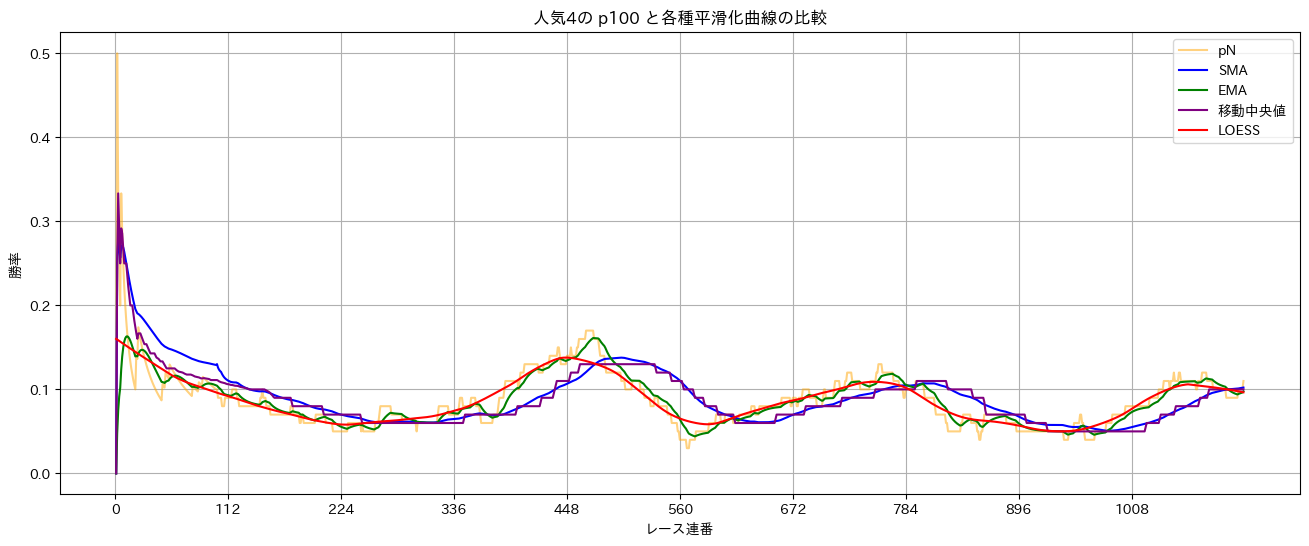

In [869]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# --- 対象人気を指定 ---
target_popularity = 4
df_plot = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()
df_plot['is_win'] = (df_plot['finish_rank'] == 1).astype(int)

# --- p100 / pN 計算 ---
WINDOW_LONG = 60
N = 100 # 10,20,50,100
df_plot['p100'] = df_plot['is_win'].rolling(WINDOW_LONG, min_periods=1).mean().shift(1)
df_plot['pN'] = df_plot['is_win'].rolling(N, min_periods=1).mean().shift(1)

# --- 移動平均 (SMA) ---
df_plot['pN_SMA'] = df_plot['pN'].rolling(N, min_periods=1).mean()

# --- 指数移動平均 (EMA) ---
EMA_SPAN = 20  # 半減期的なスパン
df_plot['pN_EMA'] = df_plot['pN'].ewm(span=EMA_SPAN, adjust=False).mean()

# --- 移動中央値 ---
df_plot['pN_median'] = df_plot['pN'].rolling(N, min_periods=1).median()

# --- LOESS（局所回帰） ---
frac = 0.1  # データ全体に対する窓の比率。小さいほど滑らか
loess_result = lowess(df_plot['pN'], np.arange(len(df_plot)), frac=frac, return_sorted=False)
df_plot['pN_LOESS'] = loess_result

# --- グラフ作成 ---
plt.figure(figsize=(16, 6))
x = np.arange(len(df_plot))

plt.plot(x, df_plot['pN'], label='pN', color='orange', alpha=0.5)
plt.plot(x, df_plot['pN_SMA'], label='SMA', color='blue')
plt.plot(x, df_plot['pN_EMA'], label='EMA', color='green')
plt.plot(x, df_plot['pN_median'], label='移動中央値', color='purple')
plt.plot(x, df_plot['pN_LOESS'], label='LOESS', color='red')

# 横軸の目盛りは一定間隔
step = max(1, len(x)//10)
plt.xticks(ticks=np.arange(0, len(x), step))

plt.xlabel('レース連番')
plt.ylabel('勝率')
plt.title(f'人気{target_popularity}の p{N} と各種平滑化曲線の比較')
plt.legend()
plt.grid(True)
plt.show()


In [873]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.nonparametric.smoothers_lowess import lowess

# --- 信頼区間関数 ---
def confidence_interval(mean: float, std: float, n: int, confidence: float = 0.9):
    if n <= 1 or std == 0:
        return (mean, mean)
    t_value = stats.t.ppf((1 + confidence) / 2, df=n - 1)
    margin = t_value * std / np.sqrt(n)
    return (mean - margin, mean + margin)

# --- パラメータ設定 ---
target_popularity = 4
N = 100
bet_amount = 100
EMA_SPAN = 20
prob_threshold = 0.5  # 例：購入する確率閾値
loess_frac = 0.1      # LOESS平滑化のウィンドウ比率（0.0〜1.0）

# --- odds範囲設定 ---
min_odds = 1.1
max_odds = 100

# --- データ読み込み ---
df_plot = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()
df_plot['is_win'] = (df_plot['finish_rank'] == 1).astype(int)

# --- 勝率・EMA計算 ---
df_plot['pN'] = df_plot['is_win'].rolling(N, min_periods=1).mean().shift(1)
df_plot['EMA'] = df_plot['pN'].ewm(span=EMA_SPAN, adjust=False).mean()
df_plot['EMA_slope'] = df_plot['EMA'].diff()

# --- LOESS 平滑化と傾き計算 ---
x = np.arange(len(df_plot))
loess_smoothed = lowess(df_plot['pN'], x, frac=loess_frac, return_sorted=False)
df_plot['loess'] = loess_smoothed
df_plot['loess_slope'] = np.gradient(loess_smoothed)  # 傾き（数値微分）

# --- LOESS傾きの2次微分 ---
df_plot['loess_slope2'] = np.gradient(df_plot['loess_slope'])

# --- 各条件ロジック定義（prob条件付き） ---
df_plot['cond_trend_prob'] = (df_plot['EMA_slope'] > 0) & (df_plot['pred_prob_m1'] >= prob_threshold)
df_plot['cond_mean_rev_prob'] = (df_plot['pN'] < df_plot['EMA']) & (df_plot['pred_prob_m1'] >= prob_threshold)
df_plot['cond_hybrid_prob'] = (df_plot['EMA_slope'] > 0) & (df_plot['pN'] < df_plot['EMA']) & (df_plot['pred_prob_m1'] >= prob_threshold)
df_plot['cond_slope_strong_prob'] = (df_plot['EMA_slope'] > df_plot['EMA_slope'].quantile(0.75)) & (df_plot['pred_prob_m1'] >= prob_threshold)
df_plot['cond_cross_prob'] = ((df_plot['pN'].shift(1) < df_plot['EMA'].shift(1)) & (df_plot['pN'] >= df_plot['EMA'])) & (df_plot['pred_prob_m1'] >= prob_threshold)
df_plot['cond_loess_slope_prob'] = (df_plot['loess_slope'] > 0) & (df_plot['pred_prob_m1'] >= prob_threshold)
df_plot['cond_loess_hybrid_prob'] = (df_plot['loess_slope'] > 0) & (df_plot['pN'] < df_plot['loess']) & (df_plot['pred_prob_m1'] >= prob_threshold)

# --- 修正版⑧：LOESS傾き>0かつLOESS傾きの傾き>0 ---
df_plot['cond_loess_slope2_prob'] = (df_plot['loess_slope'] > 0) & (df_plot['loess_slope2'] > 0) & (df_plot['pred_prob_m1'] >= prob_threshold)

# --- シミュレーション関数（odds範囲対応） ---
def simulate_hits(df, cond_col=None, min_odds=None, max_odds=None):
    if cond_col:
        bets = df[df[cond_col]].copy()
    else:
        bets = df.copy()
    
    # odds範囲でフィルタ
    if min_odds is not None:
        bets = bets[bets['odds'] >= min_odds]
    if max_odds is not None:
        bets = bets[bets['odds'] <= max_odds]

    total_bets = len(bets)
    if total_bets == 0:
        return {'bets': 0, 'wins': 0, 'accuracy': 0, 'roi': 0, 'ci': (np.nan, np.nan)}

    wins = bets['is_win'].sum()
    accuracy = wins / total_bets
    bets['roi_each'] = bets['is_win'] * bets['odds']
    payout = (bets['roi_each'] * bet_amount).sum()
    total_spent = total_bets * bet_amount
    roi = payout / total_spent if total_spent > 0 else 0

    std = bets['roi_each'].std(ddof=1) if total_bets > 1 else 0
    lower, upper = confidence_interval(roi, std, total_bets)
    return {'bets': total_bets, 'wins': wins, 'accuracy': accuracy, 'roi': roi, 'ci': (lower, upper)}

# --- 8ロジックを比較（prob条件＋odds範囲対応） ---
results_prob = {
    '① トレンド追随（EMA上昇 & prob）': simulate_hits(df_plot, 'cond_trend_prob', min_odds, max_odds),
    '② 平均回帰（pN < EMA & prob）': simulate_hits(df_plot, 'cond_mean_rev_prob', min_odds, max_odds),
    '③ ハイブリッド（上昇＆平均下 & prob）': simulate_hits(df_plot, 'cond_hybrid_prob', min_odds, max_odds),
    '④ 強トレンドのみ（傾き上位25% & prob）': simulate_hits(df_plot, 'cond_slope_strong_prob', min_odds, max_odds),
    '⑤ クロス検知（pNがEMAを上抜け & prob）': simulate_hits(df_plot, 'cond_cross_prob', min_odds, max_odds),
    '⑥ LOESS傾き>0（滑らかな上昇 & prob）': simulate_hits(df_plot, 'cond_loess_slope_prob', min_odds, max_odds),
    '⑦ LOESS上昇＆pN<LOESS & prob': simulate_hits(df_plot, 'cond_loess_hybrid_prob', min_odds, max_odds),
    '⑧ LOESS傾き>0かつ傾きの傾き>0': simulate_hits(df_plot, 'cond_loess_slope2_prob', min_odds, max_odds),
}

# --- 出力 ---
print("\n==============================")
print(f"🎯 人気{target_popularity}番の 8ロジック比較")
print("==============================")

# --- 設定パラメータの表示 ---
print("\n--- 設定パラメータ ---")
params = {
    "target_popularity": target_popularity,
    "N": N,
    "bet_amount": bet_amount,
    "EMA_SPAN": EMA_SPAN,
    "prob_threshold": prob_threshold,
    "loess_frac": loess_frac,
    "min_odds": min_odds,
    "max_odds": max_odds,
}
for k, v in params.items():
    print(f"{k}: {v}")

# --- 各ロジックの結果表示 ---
for key, res in results_prob.items():
    print(f"\n--- {key} ---")
    print(f"購入数: {res['bets']}、的中数: {res['wins']}")
    print(f"的中率: {res['accuracy']:.2%}")
    print(f"回収率: {res['roi']:.3f}")
    print(f"90%信頼区間: ({res['ci'][0]:.3f}, {res['ci'][1]:.3f})")



🎯 人気4番の 8ロジック比較

--- 設定パラメータ ---
target_popularity: 4
N: 100
bet_amount: 100
EMA_SPAN: 20
prob_threshold: 0.5
loess_frac: 0.1
min_odds: 1.1
max_odds: 100

--- ① トレンド追随（EMA上昇 & prob） ---
購入数: 220、的中数: 24
的中率: 10.91%
回収率: 0.859
90%信頼区間: (0.560, 1.158)

--- ② 平均回帰（pN < EMA & prob） ---
購入数: 264、的中数: 27
的中率: 10.23%
回収率: 0.927
90%信頼区間: (0.614, 1.240)

--- ③ ハイブリッド（上昇＆平均下 & prob） ---
購入数: 0、的中数: 0
的中率: 0.00%
回収率: 0.000
90%信頼区間: (nan, nan)

--- ④ 強トレンドのみ（傾き上位25% & prob） ---
購入数: 117、的中数: 12
的中率: 10.26%
回収率: 0.792
90%信頼区間: (0.412, 1.173)

--- ⑤ クロス検知（pNがEMAを上抜け & prob） ---
購入数: 16、的中数: 3
的中率: 18.75%
回収率: 1.519
90%信頼区間: (-0.009, 3.047)

--- ⑥ LOESS傾き>0（滑らかな上昇 & prob） ---
購入数: 223、的中数: 31
的中率: 13.90%
回収率: 1.217
90%信頼区間: (0.849, 1.585)

--- ⑦ LOESS上昇＆pN<LOESS & prob ---
購入数: 115、的中数: 20
的中率: 17.39%
回収率: 1.557
90%信頼区間: (0.964, 2.151)

--- ⑧ LOESS傾き>0かつ傾きの傾き>0 ---
購入数: 113、的中数: 20
的中率: 17.70%
回収率: 1.558
90%信頼区間: (0.965, 2.152)


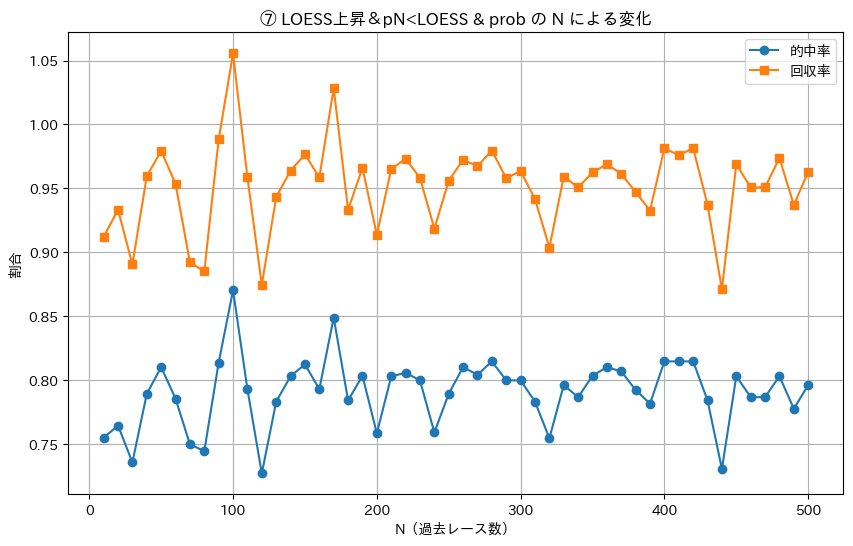

In [649]:
import matplotlib.pyplot as plt

# --- Nの範囲設定 ---
N_values = range(10, 501, 10)  # 例: 20から200まで10刻み
accuracy_list = []
roi_list = []

for N_test in N_values:
    df_plot['pN'] = df_plot['is_win'].rolling(N_test, min_periods=1).mean().shift(1)
    df_plot['EMA'] = df_plot['pN'].ewm(span=EMA_SPAN, adjust=False).mean()
    
    # LOESS はそのまま再計算
    loess_smoothed = lowess(df_plot['pN'], x, frac=loess_frac, return_sorted=False)
    df_plot['loess'] = loess_smoothed

    # ⑦条件
    df_plot['cond_loess_hybrid_prob'] = (df_plot['loess_slope'] > 0) & (df_plot['pN'] < df_plot['loess']) & (df_plot['pred_prob_m1'] >= prob_threshold)

    res = simulate_hits(df_plot, 'cond_loess_hybrid_prob', min_odds, max_odds)
    accuracy_list.append(res['accuracy'])
    roi_list.append(res['roi'])

# --- グラフ描画 ---
plt.figure(figsize=(10, 6))
plt.plot(N_values, accuracy_list, marker='o', label='的中率')
plt.plot(N_values, roi_list, marker='s', label='回収率')
plt.xlabel('N（過去レース数）')
plt.ylabel('割合')
plt.title('⑦ LOESS上昇＆pN<LOESS & prob の N による変化')
plt.grid(True)
plt.legend()
plt.show()


In [485]:
# ============================================================
# ✅ 完全統合版：確率条件 × 条件1 × 条件1.5 × Rebound × オッズ条件
# ============================================================

import pandas as pd
import numpy as np
from scipy import stats

# --- 信頼区間関数 ---
def confidence_interval(mean: float, std: float, n: int, confidence: float = 0.9):
    if n <= 1 or std == 0:
        return (mean, mean)
    t_value = stats.t.ppf((1 + confidence) / 2, df=n - 1)
    margin = t_value * std / np.sqrt(n)
    return (mean - margin, mean + margin)

# --- パラメータ設定 ---
target_popularity = 1       # 対象人気
compared_popularity = 2     # 比較人気
target_threshold = 0.5      # 対象人気の予測確率下限
compared_threshold = 1.0    # 比較人気の予測確率上限
use_prob_filter = True      # 確率フィルタを使うか
N = 50                      # 直近Nレース
WINDOW_LONG = 200           # p100のウィンドウサイズ
bet_amount = 100            # 1レースあたりの購入額
min_diff = 0.08             # 条件1.5・Reboundに必要な差
stop_margin = 0.01           # Reboundでの購入停止条件
min_odds = 1.1              # 最小オッズ
max_odds = 1000.0              # 最大オッズ

# --- データ読み込み ---
df = full_pred_df.copy()  # full_pred_df は前段で作られている前提
if 'race_date' in df.columns:
    df = df.sort_values(['race_date', 'race_id'])
else:
    df = df.sort_values('race_id')

# --- 対象人気抽出 ---
df_pop = df[df['popularity'] == target_popularity].copy()
df_pop['is_win'] = (df_pop['finish_rank'] == 1).astype(int)

# --- 確率条件フィルタ ---
if use_prob_filter:
    compared_probs = (
        df[df['popularity'] == compared_popularity]
        .loc[:, ['race_id', 'pred_prob_m1']]
        .rename(columns={'pred_prob_m1': f'pop{compared_popularity}_prob'})
    )
    df_pop = df_pop.merge(compared_probs, on='race_id', how='left')
    df_pop['cond_prob'] = (
        (df_pop['pred_prob_m1'] >= target_threshold) &
        (df_pop[f'pop{compared_popularity}_prob'] <= compared_threshold)
    )
else:
    df_pop['cond_prob'] = True

# --- オッズ条件フィルタ ---
df_pop['cond_odds'] = (df_pop['odds'] >= min_odds) & (df_pop['odds'] <= max_odds)

# --- p100 / pN 計算（WINDOW_LONG未満のレースはNaN扱い） ---
df_pop['p100'] = df_pop['is_win'].rolling(WINDOW_LONG, min_periods=WINDOW_LONG).mean().shift(1)
df_pop['pN'] = df_pop['is_win'].rolling(N, min_periods=1).mean().shift(1)

# --- 条件1: pN < p100（不調期購入） ---
df_pop['cond_pN_lt_p100'] = df_pop['pN'] < df_pop['p100']

# --- 条件1.5: 中間策（pN < p100 - min_diffで購入開始、pN >= p100で停止） ---
df_pop['cond_intermediate'] = False
is_active = False
for i in range(len(df_pop)):
    if not is_active and pd.notna(df_pop['p100'].iloc[i]) and df_pop['pN'].iloc[i] < df_pop['p100'].iloc[i] - min_diff:
        is_active = True
    if is_active:
        df_pop.at[df_pop.index[i], 'cond_intermediate'] = True
        if df_pop['pN'].iloc[i] >= df_pop['p100'].iloc[i]:
            is_active = False

# --- 条件2: Rebound開始（pNが上昇に転じ、pN<p100） ---
df_pop['delta_pN'] = df_pop['pN'].diff()
df_pop['cond_rebound'] = (
    (df_pop['pN'].shift(1) < df_pop['p100']) &
    (df_pop['delta_pN'] > 0) &
    ((df_pop['p100'] - df_pop['pN']) >= min_diff)
)

# --- 条件2継続: stop_margin対応 ---
df_pop['cond_rebound_stop'] = False
is_active = False
for i in range(len(df_pop)):
    if df_pop['cond_rebound'].iloc[i]:
        is_active = True
    if is_active:
        df_pop.at[df_pop.index[i], 'cond_rebound_stop'] = True
        if df_pop['pN'].iloc[i] >= df_pop['p100'].iloc[i] - stop_margin:
            is_active = False

# --- WINDOW_LONG未満のレースは購入対象外に設定 ---
df_pop.loc[df_pop['p100'].isna(), ['cond_pN_lt_p100', 'cond_intermediate', 'cond_rebound', 'cond_rebound_stop']] = False

# --- シミュレーション関数 ---
def simulate_hits(df, condition_column=None, confidence_level=0.90):
    if condition_column:
        bets = df[(df[condition_column] == True) & 
                  (df['cond_prob'] == True) &
                  (df['cond_odds'] == True)].copy()
    else:
        bets = df[(df['cond_prob'] == True) & (df['cond_odds'] == True)].copy()

    total_bets = len(bets)
    if total_bets == 0:
        return {'bets': 0, 'wins': 0, 'accuracy': 0, 'roi': 0, 'ci': (np.nan, np.nan)}

    wins = bets['is_win'].sum()
    accuracy = wins / total_bets
    bets['roi_each'] = bets['is_win'] * bets['odds']
    payout = (bets['roi_each'] * bet_amount).sum()
    total_spent = total_bets * bet_amount
    roi = payout / total_spent if total_spent > 0 else 0

    std = bets['roi_each'].std(ddof=1) if total_bets > 1 else 0
    lower, upper = confidence_interval(roi, std, total_bets, confidence_level)

    return {
        'bets': total_bets,
        'wins': wins,
        'accuracy': accuracy,
        'roi': roi,
        'ci': (lower, upper)
    }

# --- 結果比較 ---
results = {
    'All（確率+オッズ条件）': simulate_hits(df_pop),
    'pN < p100（不調期購入）': simulate_hits(df_pop, 'cond_pN_lt_p100'),
    '条件1.5（中間策）': simulate_hits(df_pop, 'cond_intermediate'),
    'Rebound開始（反発検知）': simulate_hits(df_pop, 'cond_rebound'),
    f'Rebound継続（stop_margin={stop_margin}）': simulate_hits(df_pop, 'cond_rebound_stop')
}

# --- 出力 ---
print("\n==============================")
print("📌 シミュレーションパラメータ")
print("==============================")
params = {
    "対象人気": target_popularity,
    "比較人気": compared_popularity,
    "対象人気の確率下限": target_threshold,
    "比較人気の確率上限": compared_threshold,
    "確率フィルタ使用": use_prob_filter,
    "直近Nレース": N,
    "p100ウィンドウサイズ": WINDOW_LONG,
    "ベット額": bet_amount,
    "条件差分 min_diff": min_diff,
    "Rebound停止マージン stop_margin": stop_margin,
    "最小オッズ": min_odds,
    "最大オッズ": max_odds
}

for k, v in params.items():
    print(f"{k}: {v}")

print("\n==============================")
print("📌 結果比較")
print("==============================")

for key, res in results.items():
    print(f"\n--- {key} ---")
    print(f"購入数: {res['bets']}、的中数: {res['wins']}")
    print(f"的中率: {res['accuracy']:.2%}")
    print(f"回収率: {res['roi']:.3f}")
    print(f"90%信頼区間: ({res['ci'][0]:.3f}, {res['ci'][1]:.3f})")

# --- CSV出力 ---
df_pop.to_csv(
    f'C:\\Users\\ryo\\Downloads\\pop{target_popularity}_prob_rebound_odds_analysis.csv',
    index=False, encoding='cp932'
)



📌 シミュレーションパラメータ
対象人気: 1
比較人気: 2
対象人気の確率下限: 0.5
比較人気の確率上限: 1.0
確率フィルタ使用: True
直近Nレース: 50
p100ウィンドウサイズ: 200
ベット額: 100
条件差分 min_diff: 0.08
Rebound停止マージン stop_margin: 0.01
最小オッズ: 1.1
最大オッズ: 1000.0

📌 結果比較

--- All（確率+オッズ条件） ---
購入数: 1011、的中数: 442
的中率: 43.72%
回収率: 0.762
90%信頼区間: (0.714, 0.811)

--- pN < p100（不調期購入） ---
購入数: 474、的中数: 204
的中率: 43.04%
回収率: 0.768
90%信頼区間: (0.695, 0.841)

--- 条件1.5（中間策） ---
購入数: 174、的中数: 67
的中率: 38.51%
回収率: 0.689
90%信頼区間: (0.571, 0.806)

--- Rebound開始（反発検知） ---
購入数: 11、的中数: 5
的中率: 45.45%
回収率: 0.764
90%信頼区間: (0.231, 1.296)

--- Rebound継続（stop_margin=0.01） ---
購入数: 154、的中数: 62
的中率: 40.26%
回収率: 0.716
90%信頼区間: (0.591, 0.841)


In [809]:
'''

▼ 条件：12頭 ＆ 欠損許容12頭 ＆ 1番人気の予測確率 >= 0.8 ＆ 2番人気の予測確率 <= 0.5 ＆ オッズ 1.5〜1000.0
  購入数: 45
  的中数: 21
  的中率: 0.4667（46.67%）
  回収率: 1.0556（105.56%）
信頼区間: (0.746, 1.365)

▼ 条件：12頭 ＆ 欠損許容12頭 ＆ 1番人気の予測確率 >= 0.8 ＆ 2番人気の予測確率 <= 0.5 ＆ オッズ 1.7〜1000.0
  購入数: 34
  的中数: 15
  的中率: 0.4412（44.12%）
  回収率: 1.1235（112.35%）
信頼区間: (0.732, 1.515)

▼ 条件：12頭 ＆ 欠損許容12頭 ＆ 1番人気の予測確率 >= 0.85 ＆ 2番人気の予測確率 <= 0.55 ＆ オッズ 1.5〜1000.0
  購入数: 41
  的中数: 19
  的中率: 0.4634（46.34%）
  回収率: 1.0683（106.83%）
信頼区間: (0.736, 1.400)

▼ 条件：12頭 ＆ 欠損許容12頭 ＆ 1番人気の予測確率 >= 0.8 ＆ 2番人気の予測確率 <= 0.55 ＆ オッズ 2.5〜1000.0
  購入数: 27
  的中数: 11
  的中率: 0.4074（40.74%）
  回収率: 1.2185（121.85%）
信頼区間: (0.723, 1.714)

▼ 条件：12頭 ＆ 欠損許容12頭 ＆ 1番人気の予測確率 >= 0.9 ＆ 2番人気の予測確率 <= 0.6 ＆ オッズ 1.1〜1000.0
  購入数: 20
  的中数: 13
  的中率: 0.6500（65.00%）
  回収率: 1.2100（121.00%）
信頼区間: (0.768, 1.652)

▼ 条件：12頭 ＆ 欠損許容12頭 ＆ 1番人気の予測確率 >= 0.9 ＆ 2番人気の予測確率 <= 0.65 ＆ オッズ 1.1〜1000.0
  購入数: 28
  的中数: 18
  的中率: 0.6429（64.29%）
  回収率: 1.0750（107.50%）
信頼区間: (0.743, 1.407)

▼ 条件：11頭 ＆ 欠損許容11頭 ＆ 1番人気の予測確率 >= 0.5 ＆ 2番人気の予測確率 <= 1.0 ＆ オッズ 2.7〜1000.0
  購入数: 74
  的中数: 24
  的中率: 0.3243（32.43%）
  回収率: 0.9865（98.65%）
信頼区間: (0.706, 1.267)

▼ 条件：11頭 ＆ 欠損許容11頭 ＆ 1番人気の予測確率 >= 0.8 ＆ 2番人気の予測確率 <= 0.65 ＆ オッズ 1.1〜100.0
  購入数: 17
  的中数: 11
  的中率: 0.6471（64.71%）
  回収率: 1.0235（102.35%）
信頼区間: (0.652, 1.396)

▼ 条件：11頭 ＆ 欠損許容11頭 ＆ 1番人気の予測確率 >= 0.87 ＆ 2番人気の予測確率 <= 0.72 ＆ オッズ 1.1〜100.0
  購入数: 50
  的中数: 33
  的中率: 0.6600（66.00%）
  回収率: 0.9900（99.00%）
信頼区間: (0.810, 1.170)

 条件：11頭 ＆ 欠損許容11頭 ＆ 1番人気の予測確率 >= 0.9 ＆ 2番人気の予測確率 <= 1.0 ＆ オッズ 1.1〜100.0
  購入数: 29
  的中数: 20
  的中率: 0.6897（68.97%）
  回収率: 1.0034（100.34%）
信頼区間: (0.775, 1.232)

target_race_numbers = [10, 12]
▼ 条件：9頭 ＆ 欠損許容9頭 ＆ 3番人気の予測確率 >= 0.5 ＆ 2番人気の予測確率 <= 0.5 ＆ オッズ 1.1〜20.0
  購入数: 29
  的中数: 5
  的中率: 0.1724（17.24%）
  回収率: 1.1241（112.41%）
信頼区間: (0.316, 1.932)
target_race_numbers = [10, 12]
▼ 条件：9頭 ＆ 欠損許容9頭 ＆ 2番人気の予測確率 >= 0.0 ＆ 1番人気の予測確率 <= 1.0 ＆ オッズ 1.1〜10.0
  購入数: 166
  的中数: 51
  的中率: 0.3072（30.72%）
  回収率: 1.1271（112.71%）
信頼区間: (0.895, 1.359)
target_race_numbers = [10, 12]
▼ 条件：9頭 ＆ 欠損許容9頭 ＆ 2番人気の予測確率 >= 0.5 ＆ 1番人気の予測確率 <= 1.0 ＆ オッズ 1.1〜10.0
  購入数: 126
  的中数: 45
  的中率: 0.3571（35.71%）
  回収率: 1.3143（131.43%）
信頼区間: (1.035, 1.593) # 信頼区間が1.0を超えた！しかも 1番人気の予測確率 <= 1.0 で！
 target_race_numbers = [10, 12]
▼ 条件：9頭 ＆ 欠損許容9頭 ＆ 2番人気の予測確率 >= 0.5 ＆ 1番人気の予測確率 <= 0.75 ＆ オッズ 1.1〜10.0
  購入数: 76
  的中数: 25
  的中率: 0.3289（32.89%）
  回収率: 1.1592（115.92%）
信頼区間: (0.830, 1.488)
target_race_numbers = [10, 12]
▼ 条件：9頭 ＆ 欠損許容9頭 ＆ 2番人気の予測確率 >= 0.5 ＆ 1番人気の予測確率 <= 0.69 ＆ オッズ 1.1〜10.0
  購入数: 48
  的中数: 18
  的中率: 0.3750（37.50%）
  回収率: 1.3812（138.12%）
信頼区間: (0.929, 1.834)
target_race_numbers = [10, 12]
▼ 条件：9頭 ＆ 欠損許容9頭 ＆ 2番人気の予測確率 >= 0.5 ＆ 1番人気の予測確率 <= 0.67 ＆ オッズ 1.1〜10.0
  購入数: 42
  的中数: 14
  的中率: 0.3333（33.33%）
  回収率: 1.2952（129.52%）
信頼区間: (0.800, 1.790)
target_race_numbers = [10, 12]
▼ 条件：9頭 ＆ 欠損許容9頭 ＆ 2番人気の予測確率 >= 0.58 ＆ 1番人気の予測確率 <= 0.67 ＆ オッズ 1.1〜10.0
  購入数: 31
  的中数: 12
  的中率: 0.3871（38.71%）
  回収率: 1.4710（147.10%）
信頼区間: (0.879, 2.063)

▼ 条件：12頭 ＆ 欠損許容10頭 ＆ 1番人気の予測確率 >= 0.87 ＆ 2番人気の予測確率 <= 0.65 ＆ オッズ 1.9〜10.0
  購入数: 34
  的中数: 16
  的中率: 0.4706（47.06%）
  回収率: 1.1882（118.82%）
信頼区間: (0.804, 1.573)

▼ 条件：10頭 ＆ 欠損許容10頭 ＆ 1番人気の予測確率 >= 0.7 ＆ 2番人気の予測確率 <= 0.6 ＆ オッズ 2.1〜10.0
  購入数: 58
  的中数: 24
  的中率: 0.4138（41.38%）
  回収率: 1.1328（113.28%）
信頼区間: (0.823, 1.442)

12Rのみ。1番人気の予測確率が低めなのにこの的中率はすごい
▼ 条件：10頭 ＆ 欠損許容10頭 ＆ 1番人気の予測確率 >= 0.65 ＆ 2番人気の予測確率 <= 0.65 ＆ オッズ 1.1〜10.0
  購入数: 28
  的中数: 17
  的中率: 0.6071（60.71%）
  回収率: 1.1571（115.71%）
信頼区間: (0.808, 1.506)
1番人気の予測確率を上げてみた。
▼ 条件：10頭 ＆ 欠損許容10頭 ＆ 1番人気の予測確率 >= 0.7 ＆ 2番人気の予測確率 <= 0.65 ＆ オッズ 1.1〜10.0
  購入数: 25
  的中数: 16
  的中率: 0.6400（64.00%）
  回収率: 1.1960（119.60%）
信頼区間: (0.832, 1.560)
▼ 条件：10頭 ＆ 欠損許容10頭 ＆ 1番人気の予測確率 >= 0.75 ＆ 2番人気の予測確率 <= 0.65 ＆ オッズ 1.1〜10.0
  購入数: 20
  的中数: 15
  的中率: 0.7500（75.00%）
  回収率: 1.3450（134.50%）
信頼区間: (0.971, 1.719) # 信頼区間が高い！
'''
### 【出力メモ】
### 2023年を学習し2024年を検証した場合
# ▼ 条件：3番人気の予測確率 >= 0.75 ＆ 1番人気の予測確率 <= 0.6
#   購入数: 42
#   的中数: 13
#   的中率: 0.3095（30.95%）
#   回収率: 1.4762（147.62%）
# ▼ 条件：3番人気の予測確率 >= 0.7 ＆ 1番人気の予測確率 <= 0.6
#   購入数: 76
#   的中数: 22
#   的中率: 0.2895（28.95%）
#   回収率: 1.4132（141.32%）
# ▼ 条件：3番人気の予測確率 >= 0.7 ＆ 1番人気の予測確率 <= 0.5
#   購入数: 37
#   的中数: 14
#   的中率: 0.3784（37.84%）
#   回収率: 1.7027（170.27%）
# ▼ 条件：4番人気の予測確率 >= 0.75 ＆ 1番人気の予測確率 <= 0.55
#   購入数: 20
#   的中数: 3
#   的中率: 0.1500（15.00%）
#   回収率: 1.3150（131.50%）
# ▼ 条件：5番人気の予測確率 >= 0.65 ＆ 1番人気の予測確率 <= 0.5
#   購入数: 23
#   的中数: 4
#   的中率: 0.1739（17.39%）
#   回収率: 1.9478（194.78%）
### 2022年を学習し2023年を検証した場合
# ▼ 条件：3番人気の予測確率 >= 0.8 ＆ 1番人気の予測確率 <= 0.6
#   購入数: 21
#   的中数: 5
#   的中率: 0.2381（23.81%）
#   回収率: 1.2429（124.29%）
# ▼ 条件：4番人気の予測確率 >= 0.7 ＆ 1番人気の予測確率 <= 0.5
#   購入数: 23
#   的中数: 3
#   的中率: 0.1304（13.04%）
#   回収率: 1.2217（122.17%）
# ▼ 条件：6番人気の予測確率 >= 0.45 ＆ 1番人気の予測確率 <= 0.5
#   購入数: 66
#   的中数: 7
#   的中率: 0.1061（10.61%）
#   回収率: 1.6106（161.06%）
### 2021年を学習し2022年を検証した場合
# ▼ 条件：3番人気の予測確率 >= 0.75 ＆ 1番人気の予測確率 <= 0.6
#   購入数: 62
#   的中数: 14
#   的中率: 0.2258（22.58%）
#   回収率: 1.1194（111.94%）






'\n\n▼ 条件：12頭 ＆ 欠損許容12頭 ＆ 1番人気の予測確率 >= 0.9 ＆ 2番人気の予測確率 <= 0.65 ＆ オッズ 1.1〜1000.0\n  購入数: 28\n  的中数: 18\n  的中率: 0.6429（64.29%）\n  回収率: 1.0750（107.50%）\n信頼区間: (0.743, 1.407)\n\n▼ 条件：11頭 ＆ 欠損許容11頭 ＆ 1番人気の予測確率 >= 0.5 ＆ 2番人気の予測確率 <= 1.0 ＆ オッズ 2.7〜1000.0\n  購入数: 74\n  的中数: 24\n  的中率: 0.3243（32.43%）\n  回収率: 0.9865（98.65%）\n信頼区間: (0.706, 1.267)\n\n▼ 条件：11頭 ＆ 欠損許容11頭 ＆ 1番人気の予測確率 >= 0.8 ＆ 2番人気の予測確率 <= 0.65 ＆ オッズ 1.1〜100.0\n  購入数: 17\n  的中数: 11\n  的中率: 0.6471（64.71%）\n  回収率: 1.0235（102.35%）\n信頼区間: (0.652, 1.396)\n\n▼ 条件：11頭 ＆ 欠損許容11頭 ＆ 1番人気の予測確率 >= 0.87 ＆ 2番人気の予測確率 <= 0.72 ＆ オッズ 1.1〜100.0\n  購入数: 50\n  的中数: 33\n  的中率: 0.6600（66.00%）\n  回収率: 0.9900（99.00%）\n信頼区間: (0.810, 1.170)\n\n 条件：11頭 ＆ 欠損許容11頭 ＆ 1番人気の予測確率 >= 0.9 ＆ 2番人気の予測確率 <= 1.0 ＆ オッズ 1.1〜100.0\n  購入数: 29\n  的中数: 20\n  的中率: 0.6897（68.97%）\n  回収率: 1.0034（100.34%）\n信頼区間: (0.775, 1.232)\n\ntarget_race_numbers = [10, 12]\n▼ 条件：9頭 ＆ 欠損許容9頭 ＆ 3番人気の予測確率 >= 0.5 ＆ 2番人気の予測確率 <= 0.5 ＆ オッズ 1.1〜20.0\n  購入数: 29\n  的中数: 5\n  的中率: 0.1724（17.24%）\n  回収率: 1.1

C:\Users\ryo\AppData\Local\Temp\ipykernel_8124\1097169726.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_fixed_pop.groupby('prob_bin')


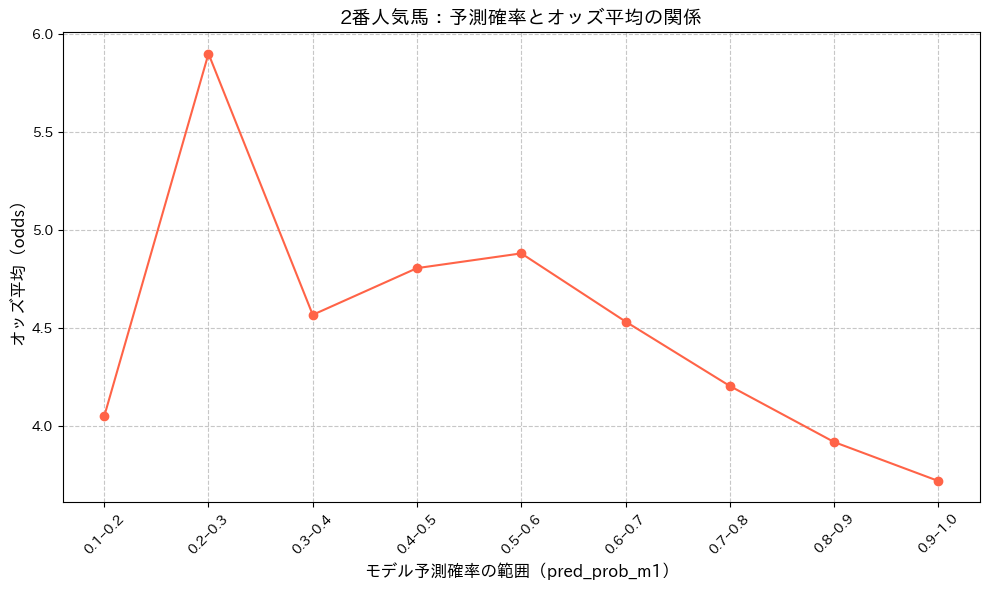

  prob_bin  サンプル数     オッズ平均
0  0.0–0.1      0       NaN
1  0.1–0.2      8  4.050000
2  0.2–0.3     18  5.900000
3  0.3–0.4     34  4.567647
4  0.4–0.5    102  4.805882
5  0.5–0.6    239  4.881172
6  0.6–0.7    402  4.533333
7  0.7–0.8    492  4.204675
8  0.8–0.9    320  3.918750
9  0.9–1.0     30  3.720000


In [41]:
# ▼ パラメータ（任意の人気を指定）
target_popularity = 2

# ▼ 1. 指定人気だけ抽出
df_fixed_pop = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()

# ▼ 2. モデル予測確率でビン分け（0.0〜1.0 を 0.1刻み）
bins = np.arange(0, 1.01, 0.1)
labels = [f'{round(bins[i],2)}–{round(bins[i+1],2)}' for i in range(len(bins)-1)]
df_fixed_pop['prob_bin'] = pd.cut(df_fixed_pop['pred_prob_m1'], bins=bins, labels=labels, include_lowest=True)

# ▼ 3. 各ビンごとのオッズ平均を計算
odds_stats = (
    df_fixed_pop.groupby('prob_bin')
    .agg(
        サンプル数=('odds', 'count'),
        オッズ平均=('odds', 'mean')
    )
    .reset_index()
)

# ▼ 4. グラフ表示
plt.figure(figsize=(10, 6))
plt.plot(odds_stats['prob_bin'], odds_stats['オッズ平均'], marker='o', linestyle='-', color='tomato')
plt.xlabel('モデル予測確率の範囲（pred_prob_m1）', fontsize=12)
plt.ylabel('オッズ平均（odds）', fontsize=12)
plt.title(f'{target_popularity}番人気馬：予測確率とオッズ平均の関係', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ▼ 表の出力（確認用）
print(odds_stats)

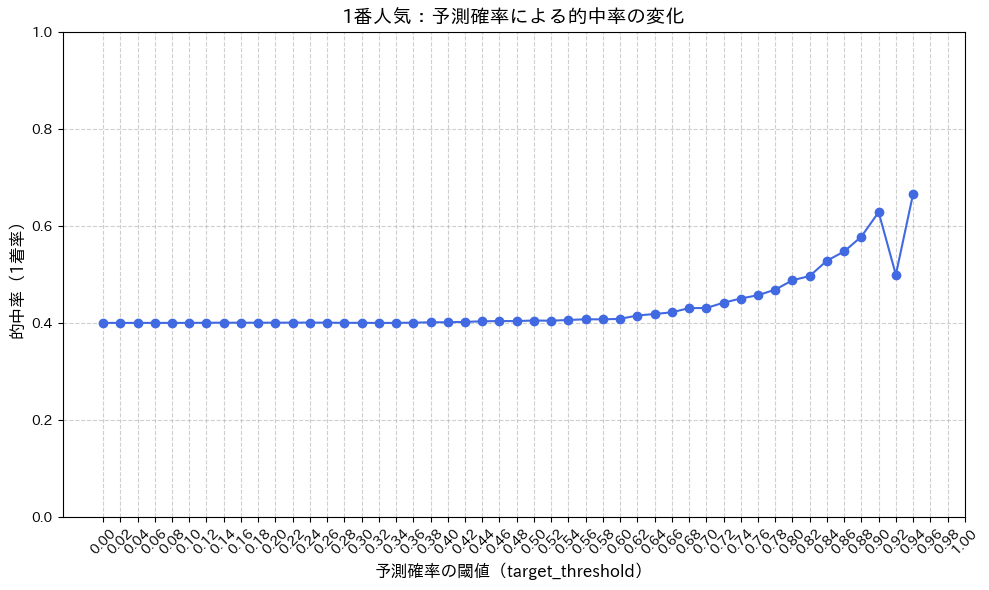

In [343]:
import numpy as np
import matplotlib.pyplot as plt

# ▼ 指定する人気
target_popularity = 1

# ▼ データのフィルタ：指定人気の馬だけ
df_target_pop = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()

# ▼ 閾値の範囲（0.0〜1.0 を 0.05刻みで）
thresholds = np.arange(0.0, 1.01, 0.02)

hit_rates = []  # 的中率リスト

for thresh in thresholds:
    df_thresh = df_target_pop[df_target_pop['pred_prob_m1'] >= thresh]
    total = len(df_thresh)
    if total == 0:
        hit_rate = np.nan  # データなしの場合はNaN
    else:
        hits = (df_thresh['finish_rank'] == 1).sum()
        hit_rate = hits / total
    hit_rates.append(hit_rate)

# ▼ グラフの描画
plt.figure(figsize=(10, 6))
plt.plot(thresholds, hit_rates, marker='o', linestyle='-', color='royalblue')
plt.xlabel('予測確率の閾値（target_threshold）', fontsize=12)
plt.ylabel('的中率（1着率）', fontsize=12)
plt.title(f'{target_popularity}番人気：予測確率による的中率の変化', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(np.round(thresholds, 2), rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


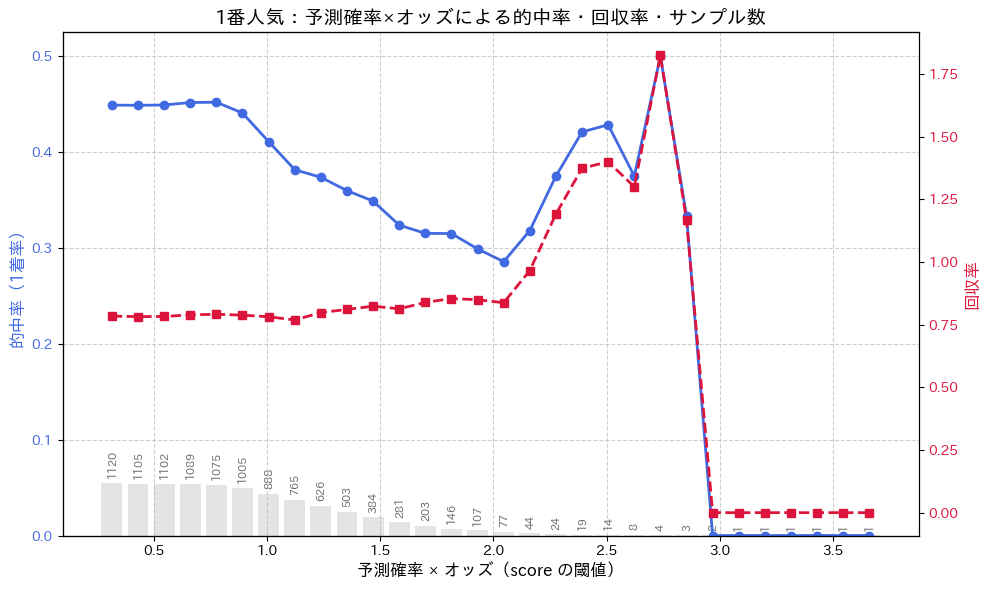

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# =============================
# 設定
# =============================
target_popularity = 1  # 対象人気
df_target_pop = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()

# スコア（予測確率 × オッズ）
df_target_pop['score'] = df_target_pop['pred_prob_m1'] * df_target_pop['odds']

# 閾値範囲（スコアに応じて）
min_score = df_target_pop['score'].min()
max_score = df_target_pop['score'].max()
thresholds = np.linspace(min_score, max_score, 30)

hit_rates = []
rois = []
sample_sizes = []

for thresh in thresholds:
    df_thresh = df_target_pop[df_target_pop['score'] >= thresh]
    n = len(df_thresh)
    sample_sizes.append(n)

    if n == 0:
        hit_rates.append(np.nan)
        rois.append(np.nan)
        continue

    hit_count = (df_thresh['finish_rank'] == 1).sum()
    hit_rate = hit_count / n
    return_sum = df_thresh.loc[df_thresh['finish_rank'] == 1, 'odds'].sum()
    roi = return_sum / n

    hit_rates.append(hit_rate)
    rois.append(roi)

# =============================
# グラフ描画
# =============================
fig, ax1 = plt.subplots(figsize=(10, 6))

# --- 折れ線（的中率） ---
color1 = 'royalblue'
ax1.plot(thresholds, hit_rates, marker='o', color=color1, label='的中率', linewidth=2, zorder=5)
ax1.set_xlabel('予測確率 × オッズ（score の閾値）', fontsize=12)
ax1.set_ylabel('的中率（1着率）', color=color1, fontsize=12)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, linestyle='--', alpha=0.6, zorder=0)

# --- 右軸（回収率） ---
ax2 = ax1.twinx()
color2 = 'crimson'
ax2.plot(thresholds, rois, marker='s', linestyle='--', color=color2, label='回収率', linewidth=2, zorder=6)
ax2.set_ylabel('回収率', color=color2, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color2)

# --- サンプル数バー（別スケールで下部に表示） ---
ax3 = ax1.twinx()  # さらに第3軸を重ねる
ax3.spines['right'].set_position(('outward', 60))  # 少し右にずらす
ax3.set_yticks([])  # 目盛りは非表示

bar_color = 'lightgray'
bar_width = (thresholds[1] - thresholds[0]) * 0.8
bar_bottom = ax1.get_ylim()[0] - 0.05  # グラフ下に配置

# 正規化して下に薄く出す（高さ0〜0.1程度）
max_bar_height = (ax1.get_ylim()[1] - ax1.get_ylim()[0]) * 0.1
bar_heights = (np.array(sample_sizes) / max(sample_sizes)) * max_bar_height

# 棒を描画
ax1.bar(thresholds, bar_heights, width=bar_width, color=bar_color, alpha=0.6, zorder=1)

# 棒の上にサンプル数の数字を描画
for x, h, n in zip(thresholds, bar_heights, sample_sizes):
    ax1.text(x, h + ax1.get_ylim()[0] + 0.005, str(n),
             ha='center', va='bottom', fontsize=8, color='dimgray', rotation=90)

# --- タイトルなど ---
plt.title(f'{target_popularity}番人気：予測確率×オッズによる的中率・回収率・サンプル数', fontsize=14)
plt.tight_layout()
plt.show()


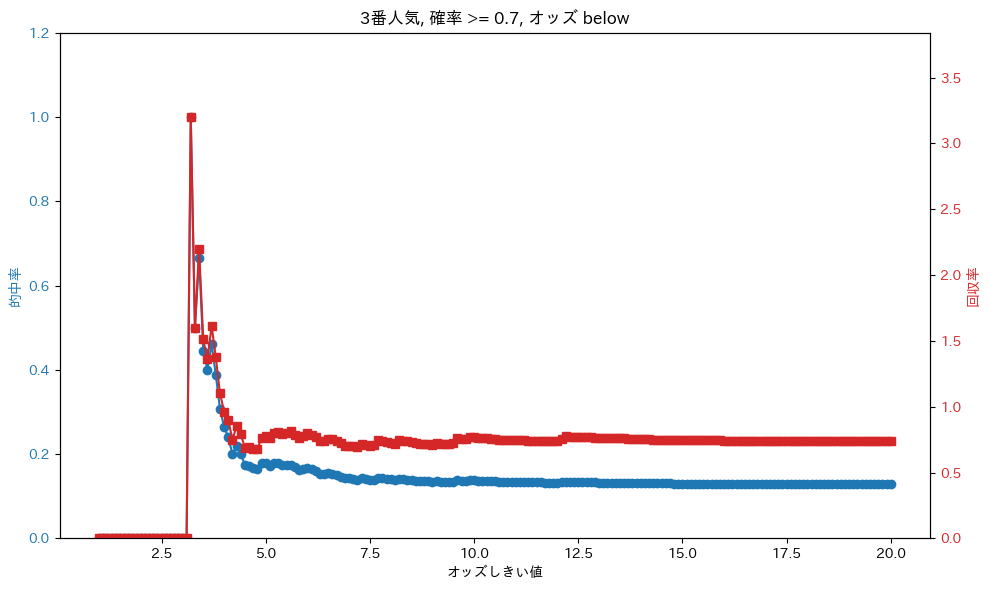

In [121]:
# ▼ パラメータ設定
target_popularity = 3
prob_threshold = 0.7
odds_min = 1.0
odds_max = 20
odds_step = 0.1
filter_type = 'below'  # 'below' or 'above'

# ▼ 該当人気だけに絞る
df_pop = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()

# ▼ モデル予測確率が高い馬を抽出
df_high_prob = df_pop[df_pop['pred_prob_m1'] >= prob_threshold].copy()

# ▼ 結果記録リスト
odds_thresholds = []
hit_rates = []
rois = []
sample_sizes = []

# ▼ オッズしきい値を変化させながら集計
odds_range = np.arange(odds_min, odds_max + odds_step, odds_step)

for threshold in odds_range:
    if filter_type == 'below':
        subset = df_high_prob[df_high_prob['odds'] <= threshold].copy()
    elif filter_type == 'above':
        subset = df_high_prob[df_high_prob['odds'] > threshold].copy()
    else:
        raise ValueError("filter_type は 'below' または 'above' にしてください")

    sample_size = len(subset)
    hit_count = (subset['finish_rank'] == 1).sum()
    return_sum = subset.loc[subset['finish_rank'] == 1, 'odds'].sum()

    hit_rate = hit_count / sample_size if sample_size > 0 else 0
    roi = return_sum / sample_size if sample_size > 0 else 0

    # 結果記録
    odds_thresholds.append(threshold)
    hit_rates.append(hit_rate)
    rois.append(roi)
    sample_sizes.append(sample_size)

# ▼ グラフ表示（的中率 & 回収率の2軸）
fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = 'tab:blue'
ax1.set_xlabel('オッズしきい値')
ax1.set_ylabel('的中率', color=color1)
ax1.plot(odds_thresholds, hit_rates, color=color1, label='的中率', marker='o')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(0, max(hit_rates) * 1.2)

# ▼ 回収率の軸
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('回収率', color=color2)
ax2.plot(odds_thresholds, rois, color=color2, label='回収率', marker='s')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0, max(rois) * 1.2)

# ▼ タイトル・凡例
plt.title(f'{target_popularity}番人気, 確率 >= {prob_threshold}, オッズ {filter_type}')
fig.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.savefig("C:\\Users\\ryo\\Downloads\\plot.png")
plt.show()


C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pop.groupby('odds_bin')
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pop.groupby('odds_bin')
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:50: UserWarning: Glyph 12458 (\N{KATAKANA LETTER O}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:50: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layo

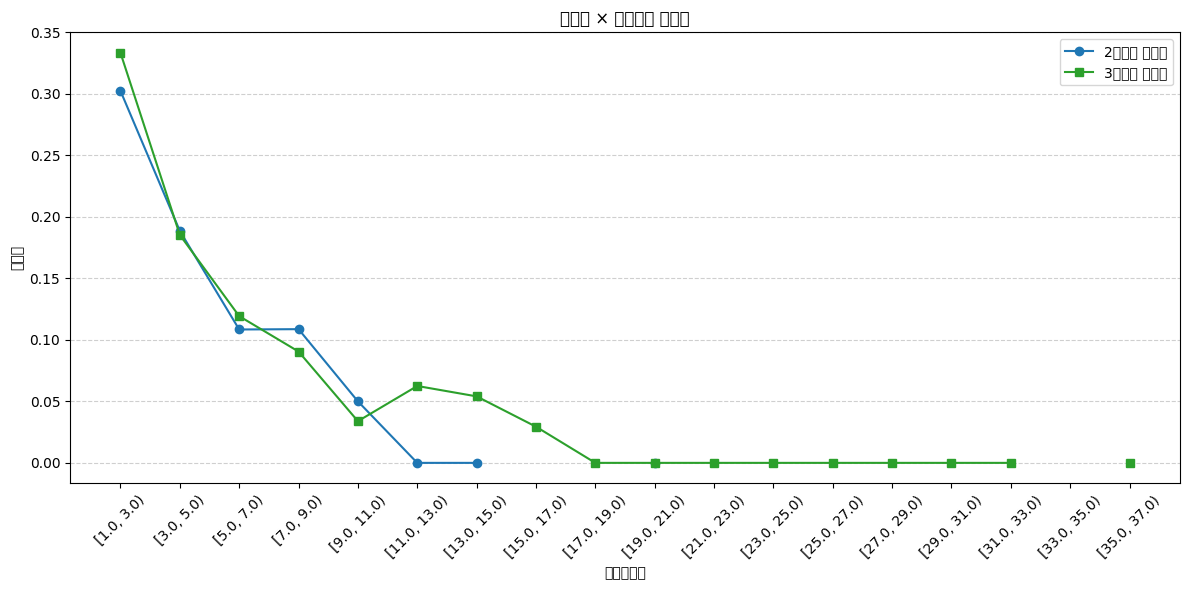

C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 12458 (\N{KATAKANA LETTER O}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 12474 (\N{KATAKANA LETTER ZU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 31684 (\N{CJK UNIFIED IDEOGRAPH-7BC4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 22258 (\N{CJK UNIFIED IDEOGRAPH-56F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missin

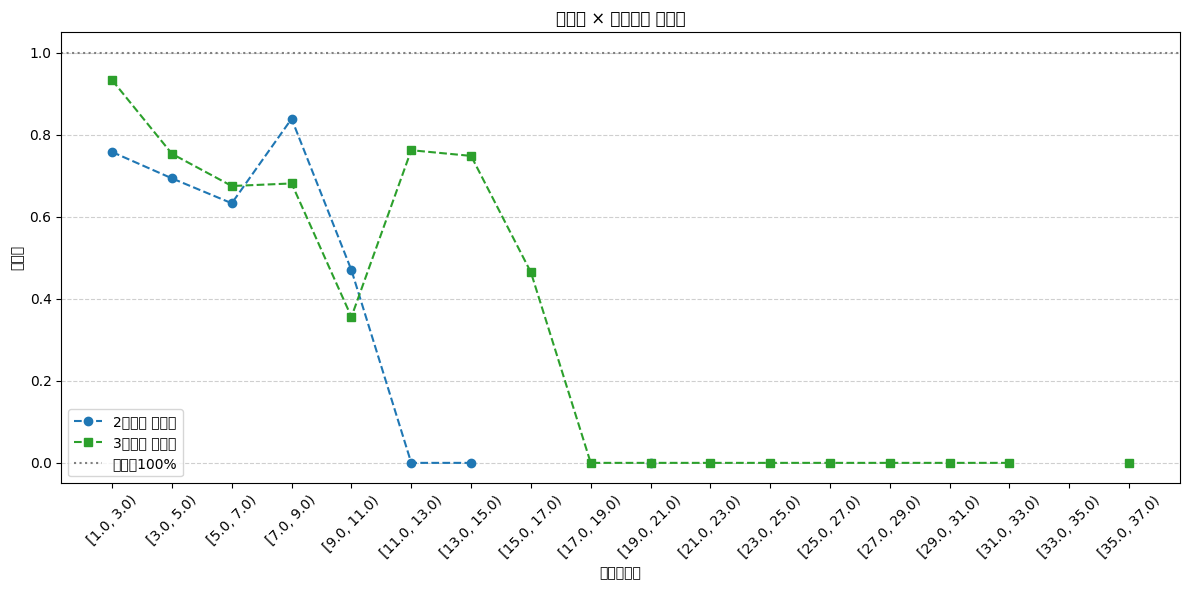

In [39]:

# -------- パラメータ --------
odds_bins = np.arange(1.0, 51.0, 2.0)  # オッズを2刻みで分割
target_popularities = [2, 3]           # 比較したい人気

# -------- データ収集 --------
plot_data = {}

for pop in target_popularities:
    df_pop = full_pred_df[full_pred_df['popularity'] == pop].copy()
    if df_pop.empty:
        continue

    df_pop['odds_bin'] = pd.cut(df_pop['odds'], bins=odds_bins, right=False)
    df_pop['hit'] = (df_pop['finish_rank'] == 1).astype(int)
    df_pop['return'] = df_pop['odds'] * df_pop['hit']

    stats = (
        df_pop.groupby('odds_bin')
        .agg(
            sample_size=('hit', 'count'),
            hit_count=('hit', 'sum'),
            return_sum=('return', 'sum')
        )
        .reset_index()
    )

    stats['hit_rate'] = stats['hit_count'] / stats['sample_size']
    stats['roi'] = stats['return_sum'] / stats['sample_size']
    stats['odds_bin_str'] = stats['odds_bin'].astype(str)
    plot_data[pop] = stats

# -------- 共通設定 --------
colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:orange', 'tab:purple']
markers = ['o', 's', 'D', '^', 'v']

# -------- グラフ①：的中率 --------
plt.figure(figsize=(12, 6))
for i, pop in enumerate(target_popularities):
    stats = plot_data[pop]
    plt.plot(stats['odds_bin_str'], stats['hit_rate'],
             label=f'{pop}番人気 的中率',
             color=colors[i % len(colors)], marker=markers[i % len(markers)])

plt.xlabel('オッズ範囲')
plt.ylabel('的中率')
plt.title('人気別 × オッズ別 的中率')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -------- グラフ②：回収率 --------
plt.figure(figsize=(12, 6))
for i, pop in enumerate(target_popularities):
    stats = plot_data[pop]
    plt.plot(stats['odds_bin_str'], stats['roi'],
             label=f'{pop}番人気 回収率',
             color=colors[i % len(colors)], marker=markers[i % len(markers)], linestyle='--')

plt.xlabel('オッズ範囲')
plt.ylabel('回収率')
plt.title('人気別 × オッズ別 回収率')
plt.xticks(rotation=45)
plt.axhline(y=1.0, color='gray', linestyle='dotted', label='回収率100%')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


C:\Users\ryo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:43:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


正答率 (accuracy): 0.6608
混同行列:
 [[ 17 114]
 [ 21 246]]
分類レポート:
               precision    recall  f1-score   support

           0       0.45      0.13      0.20       131
           1       0.68      0.92      0.78       267

    accuracy                           0.66       398
   macro avg       0.57      0.53      0.49       398
weighted avg       0.61      0.66      0.59       398


-------------------------


▼ 評価結果（3番人気）
  全体のレース数       : 398
  モデルが1と予測した数 : 360
  的中数（1着）         : 48
  払い戻し合計           : 271.90
  回収率                 : 0.7553（75.53%）
▼ 確率で購入判断（しきい値 = 0.7 ）
対象人気           : 3番人気
全体レース数       : 398
購入対象レース数   : 42
的中数             : 12
的中率             : 0.2857（28.57%）
回収率             : 1.1595（115.95%）
          feature  importance
2  pop3_pred_prob    2.988739
1  pop2_pred_prob    2.768800
6  pop7_pred_prob    2.728132
7  pop8_pred_prob    2.662507
3  pop4_pred_prob    2.534038
0  pop1_pred_prob    2.490656
5  pop6_pred_prob    2.403370
4  pop5_pred_prob    2.284997

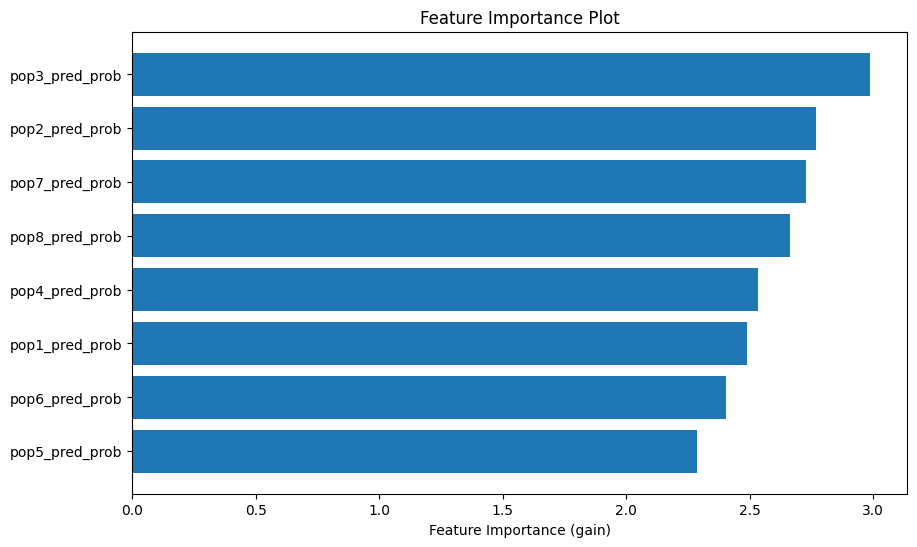

In [205]:
# 1. 人気が重複しているレースIDを特定
pop_counts = full_pred_df.groupby(['race_id', 'popularity']).size().reset_index(name='count')
duplicated_pops = pop_counts[pop_counts['count'] > 1]['race_id'].unique()

# 2. full_pred_df から除外（重複人気を含むレースは全除外）
clean_df = full_pred_df[~full_pred_df['race_id'].isin(duplicated_pops)].copy()

# 3. 人気ごとの予測確率を横持ちにする（pivot）
feature_df = clean_df.copy()
feature_df['pop_col'] = feature_df['popularity'].apply(lambda x: f'pop{x}_pred_prob')
X_all = feature_df.pivot(index='race_id', columns='pop_col', values='pred_prob_m1').reset_index()

# 4. ターゲット人気の目的変数作成（例：3番人気が1着かどうか）
target_popularity = 3
y_df = clean_df[clean_df['popularity'] == target_popularity][['race_id', 'finish_rank']].copy()
y_df['target'] = (y_df['finish_rank'] <= 4).astype(int)

# 5. 学習用にマージ
data = pd.merge(X_all, y_df[['race_id', 'target']], on='race_id', how='inner')

# 6. 特徴量・目的変数に分割
X = data.drop(columns=['race_id', 'target'])
y = data['target']

# 7. モデル学習（例：XGBoost）
from sklearn.model_selection import train_test_split
import xgboost as xgb

# race_id の先頭2桁から「年」を抽出（文字列として処理）
data['year'] = data['race_id'].astype(str).str[:2]

# 学習データ：2023年（= '23'）
train_data = data[data['year'] == '23']
X_train = train_data.drop(columns=['race_id', 'target', 'year'])
y_train = train_data['target']

# 検証データ：2024年（= '24'）
val_data = data[data['year'] == '24']
X_val = val_data.drop(columns=['race_id', 'target', 'year'])
y_val = val_data['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# ====== パラメータ定義 ======
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'random_state': 42,
    'n_estimators': 100,
    'max_depth': 4,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
}

# ====== モデル定義 ======
model = xgb.XGBClassifier(**xgb_params)
model.fit(X_train, y_train)

# 8. 評価
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(X_val)

# モデル予測
y_pred = model.predict(X_val)

# X_val に race_id を付与（元のデータから取得）
X_val_with_preds = X_val.copy()
X_val_with_preds['race_id'] = data.loc[X_val.index, 'race_id'].values
X_val_with_preds['y_true'] = y_val.values
X_val_with_preds['y_pred'] = y_pred

# race_id 単位で重複を除く（1人気あたり1行）
target_df = clean_df[clean_df['popularity'] == target_popularity][['race_id', 'odds', 'finish_rank', 'popularity']].copy()

# 予測結果と統合
eval_df = pd.merge(X_val_with_preds, target_df, on='race_id', how='left')

# ✅ 全体のレース数（重複除いてカウント）
total_races = eval_df['race_id'].nunique()

# ✅ 予測が1（=購入対象）のレースだけ抽出
bets = eval_df[eval_df['y_pred'] == 1].copy()
bets['hit'] = (bets['finish_rank'] == 1).astype(int)  # 的中 = 1着

# 購入数、的中数、払い戻し合計
num_bets = len(bets)
num_hits = bets['hit'].sum()
total_return = (bets['odds'] * bets['hit']).sum()
roi = total_return / num_bets if num_bets > 0 else 0
# 評価指標
acc = accuracy_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f"正答率 (accuracy): {acc:.4f}")
print("混同行列:\n", cm)
print("分類レポート:\n", report)
print("\n-------------------------\n")
# ✅ 出力
print(f"\n▼ 評価結果（{target_popularity}番人気）")
print(f"  全体のレース数       : {total_races}")
print(f"  モデルが1と予測した数 : {num_bets}")
print(f"  的中数（1着）         : {num_hits}")
print(f"  払い戻し合計           : {total_return:.2f}")
print(f"  回収率                 : {roi:.4f}（{roi:.2%}）")

# ====== パラメータ設定 ======
prob_threshold = 0.7      # 購入する確率のしきい値（例：0.7）
odds_threshold = 4.5      # 購入するオッズのしきい値（例：3.0）

# ====== 予測確率の取得 ======
y_proba = model.predict_proba(X_val)[:, 1]  # クラス1（1着になる確率）のみ

# ====== データ結合 ======
# X_val には race_id などの情報がないので、feature_df から race_id, odds, finish_rank を取得
val_df_with_info = eval_df[eval_df['popularity'] == target_popularity].copy()
val_df_with_info = val_df_with_info.reset_index(drop=True)  # 念のため整列

val_df_with_info['pred_prob'] = y_proba
val_df_with_info['hit'] = (val_df_with_info['finish_rank'] == 1).astype(int)

# ====== 購入するレース（確率が高いもの） ======
bets = val_df_with_info[
    (val_df_with_info['pred_prob'] >= prob_threshold) &
    (val_df_with_info['odds'] <= odds_threshold)
].copy()

# ====== 回収率・的中率計算 ======
race_count_total = len(val_df_with_info)
race_count_bet = len(bets)
hit_count = bets['hit'].sum()
hit_rate = hit_count / race_count_bet if race_count_bet > 0 else 0
total_return = bets.loc[bets['hit'] == 1, 'odds'].sum()
roi = total_return / race_count_bet if race_count_bet > 0 else 0

# ====== 結果表示 ======
print("▼ 確率で購入判断（しきい値 =", prob_threshold, "）")
print(f"対象人気           : {target_popularity}番人気")
print(f"全体レース数       : {race_count_total}")
print(f"購入対象レース数   : {race_count_bet}")
print(f"的中数             : {hit_count}")
print(f"的中率             : {hit_rate:.4f}（{hit_rate:.2%}）")
print(f"回収率             : {roi:.4f}（{roi:.2%}）")

# ====== オプション：CSV出力 ======
bets.to_csv(f'pop{target_popularity}_prob{prob_threshold}_bets.csv', index=False, encoding='cp932')

import matplotlib.pyplot as plt
import xgboost as xgb

# 1. 特徴量重要度の取得（gain, weight, cover などいろいろありますが、'gain'がよく使われます）
importance = model.get_booster().get_score(importance_type='gain')

# 2. 辞書 → DataFrame に変換して見やすく
import pandas as pd

importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
}).sort_values(by='importance', ascending=False)

print(importance_df)

# 3. 棒グラフで可視化
plt.figure(figsize=(10,6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.gca().invert_yaxis()  # 重要度の高い順に表示
plt.xlabel('Feature Importance (gain)')
plt.title('Feature Importance Plot')
plt.show()


C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36092 (\N{CJK UNIFIED IDEOGRAPH-8CFC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30906 (\N{CJK UNIFIED IDEOGRAPH-78BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12375 (\N{HIRAGANA LETTER SI}) missing from font(s) DejaVu Sans.
  fig.canvas.pr

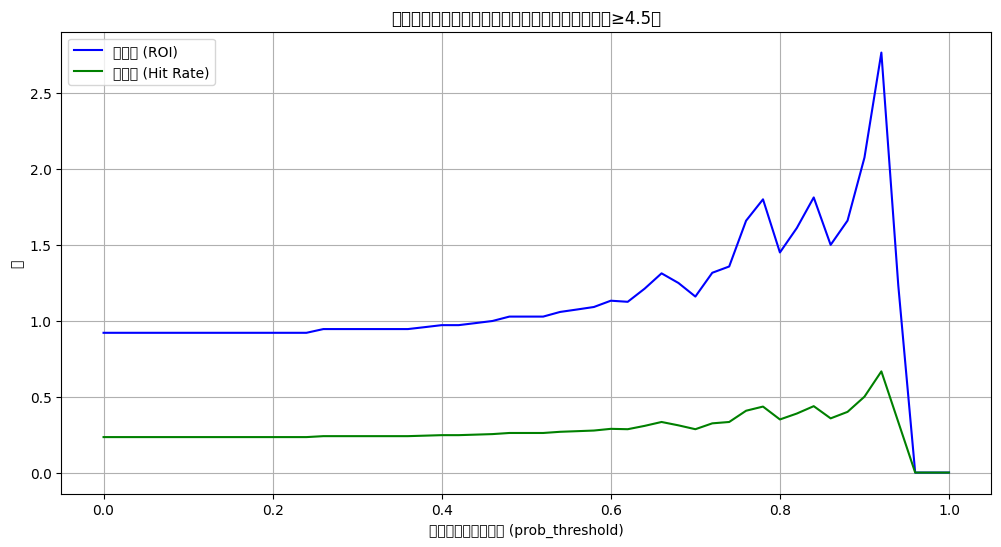

C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23550 (\N{CJK UNIFIED IDEOGRAPH-5BFE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35937 (\N{CJK UNIFIED IDEOGRAPH-8C61}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12524 (\N{KATAKANA LETTER RE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  fig.canva

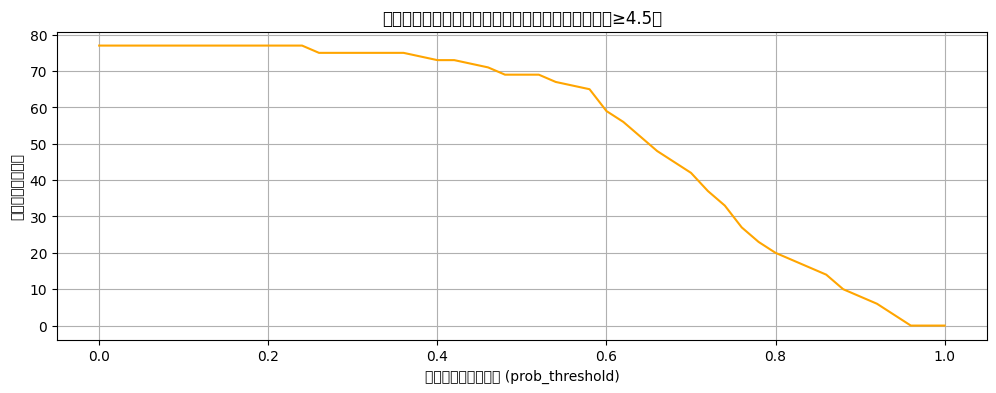

In [207]:
import numpy as np
import matplotlib.pyplot as plt

# 確率のしきい値（0〜1）
thresholds = np.arange(0.0, 1.01, 0.02)

roi_list = []
hit_rate_list = []
bet_count_list = []

for thr in thresholds:
    # 確率とオッズ両方の条件で購入判断
    bets_thr = val_df_with_info[
        (val_df_with_info['pred_prob'] >= thr) &
        (val_df_with_info['odds'] <= odds_threshold)
    ].copy()
    
    num_bets = len(bets_thr)
    if num_bets > 0:
        hits = bets_thr['hit'].sum()
        hit_rate = hits / num_bets
        total_return = bets_thr.loc[bets_thr['hit'] == 1, 'odds'].sum()
        roi = total_return / num_bets
    else:
        hit_rate = 0
        roi = 0
    
    roi_list.append(roi)
    hit_rate_list.append(hit_rate)
    bet_count_list.append(num_bets)

# グラフ描画
plt.figure(figsize=(12,6))
plt.plot(thresholds, roi_list, label='回収率 (ROI)', color='blue')
plt.plot(thresholds, hit_rate_list, label='的中率 (Hit Rate)', color='green')
plt.xlabel('購入確率のしきい値 (prob_threshold)')
plt.ylabel('率')
plt.title(f'購入確率しきい値ごとの回収率と的中率（オッズ≥{odds_threshold}）')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(thresholds, bet_count_list, label='購入対象レース数', color='orange')
plt.xlabel('購入確率のしきい値 (prob_threshold)')
plt.ylabel('購入対象レース数')
plt.title(f'購入確率しきい値ごとの購入対象レース数（オッズ≥{odds_threshold}）')
plt.grid(True)
plt.show()
